In [1]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

In [3]:
# Read the data from the CSV file
data = pd.read_csv('transliteration output.csv')
text = data['Comments'].values
labels = data['Label'].values
labels = np.where(labels == 'hate', 1, 0)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42)

In [5]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
# Tokenize the text data
X_train_tokens = tokenizer.batch_encode_plus(
    X_train,
    truncation=True,
    padding=True,
    max_length=100,
    return_tensors='tf'
)
X_test_tokens = tokenizer.batch_encode_plus(
    X_test,
    truncation=True,
    padding=True,
    max_length=100,
    return_tensors='tf'
)

In [7]:
# Build the BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [9]:
# Train the model
batch_size = 32
epochs = 3
history = model.fit(
    x=X_train_tokens['input_ids'],
    y=y_train,
    validation_data=(X_test_tokens['input_ids'], y_test),
    batch_size=batch_size,
    epochs=epochs
)

Epoch 1/3
100/100 [==============================] - 4245s 42s/step - loss: 0.6958 - accuracy: 0.4981 - val_loss: 0.6864 - val_accuracy: 0.5763
Epoch 2/3
100/100 [==============================] - 4134s 41s/step - loss: 0.6521 - accuracy: 0.6091 - val_loss: 0.6376 - val_accuracy: 0.6550
Epoch 3/3
100/100 [==============================] - 4060s 41s/step - loss: 0.5104 - accuracy: 0.7622 - val_loss: 0.5646 - val_accuracy: 0.7237


In [10]:
# Make predictions on the test set
y_pred_logits = model.predict(X_test_tokens['input_ids'])
y_pred = np.argmax(y_pred_logits.logits, axis=1)

25/25 [==============================] - 291s 12s/step


In [11]:
# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [12]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.72375
Precision: 0.8065843621399177
Recall: 0.5297297297297298
F1 Score: 0.6394779771615008


In [13]:
report = classification_report(y_test, y_pred, target_names=['non-hate', 'hate'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    non-hate       0.69      0.89      0.78       430
        hate       0.81      0.53      0.64       370

    accuracy                           0.72       800
   macro avg       0.75      0.71      0.71       800
weighted avg       0.74      0.72      0.71       800



In [14]:
# Create a DataFrame for the metrics
metrics_data = {'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1 Score': [f1]}
metrics_df = pd.DataFrame(metrics_data)

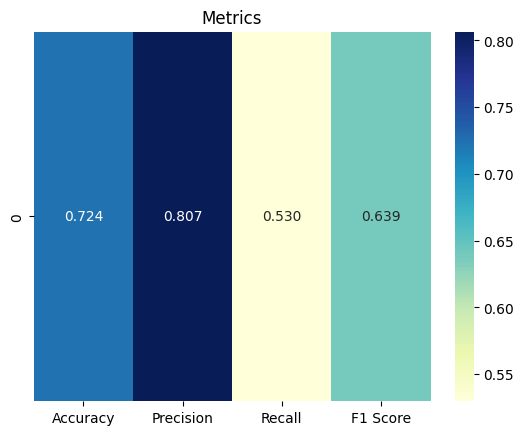

In [15]:
# Create a heatmap for the metrics
sns.heatmap(metrics_df, annot=True, cmap='YlGnBu', fmt=".3f")
plt.title('Metrics')
plt.show()

In [16]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

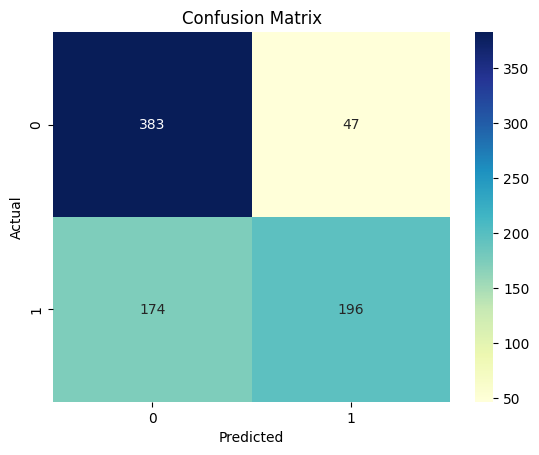

In [17]:
# Plot confusion matrix with annotations and custom color
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")  # Change the cmap parameter to your desired color scheme
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()